# Setup

### torch >= 1.13.1 cuda = 11.7 python >=3.8

### Install packages
- Install PyTorch ([pytorch.org](http://pytorch.org))
- `pip install -r requirements.txt`

# All codes were run on one NVIDIA GPU RTX2080

# Library

In [1]:
import os
import glob
import cv2
import math
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.fft as fft
from skimage import img_as_ubyte

import warnings
warnings.filterwarnings('ignore')

# Datasets
####   Our primary dataset consists of 14k face images with labels of two classes: 70k real faces from Flickr-Faces-HQ by Nvidia and 70k fake faces generated by advanced GANs and diffusion models sampled from the 1-Million-Fake-Faces provided by Bojan. We randomly split each class by a ratio of 5 to 1 to 1 and then combine both classes to form training, validation and test set. For convenience, all the images are resized to 256×256 and compressed in JPEG. We finally obtain 50k images for training, 10k images for validation and 10k images for test, each with equal number of real (labelled 0) and fake (labelled 1) faces. Here are the sources we collect data from:
 - Flickr-Faces-HQ (real faces) by Nvidia: https://github.com/NVlabs/ffhq-dataset
 - 1-Million-Fake-Faces by Bojan: https://kaggle.com/datasets/tunguz/1-million-fake-faces

### In this repository, an example of training dataset format is saved in directory ./real-vs-fake

## Show data Statistics in real training process

In [2]:
path = '/Users/kenda/Desktop/DDA4210Project/dataset/real-vs-fake/'   # change path if needed

dataset = {"img_path":[],"img_status":[],"where":[]}
for where in ['val', 'test', 'train']:
    for status in os.listdir(path+'/'+where):
        for image in glob.glob(path+'/'+where+"/"+status+"/"+"*.jpg"):
            dataset["img_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,img_path,img_status,where
0,/Users/kenda/Desktop/DDA4210Project/dataset/re...,1_fake,val
1,/Users/kenda/Desktop/DDA4210Project/dataset/re...,1_fake,val
2,/Users/kenda/Desktop/DDA4210Project/dataset/re...,1_fake,val
3,/Users/kenda/Desktop/DDA4210Project/dataset/re...,1_fake,val
4,/Users/kenda/Desktop/DDA4210Project/dataset/re...,1_fake,val
...,...,...,...
139995,/Users/kenda/Desktop/DDA4210Project/dataset/re...,0_real,train
139996,/Users/kenda/Desktop/DDA4210Project/dataset/re...,0_real,train
139997,/Users/kenda/Desktop/DDA4210Project/dataset/re...,0_real,train
139998,/Users/kenda/Desktop/DDA4210Project/dataset/re...,0_real,train


In [3]:
dataset.value_counts('img_status')

img_status
0_real    70000
1_fake    70000
dtype: int64

Real: 70000,
Fake: 70000



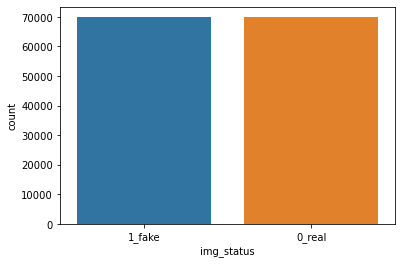

In [4]:
real = dataset.value_counts('img_status')[1]
fake = dataset.value_counts('img_status')[0]

print(f"Real: {real},\nFake: {fake}\n")
sns.countplot(dataset['img_status'])
plt.show()   # the dataset is balanced with 70000 image for each category

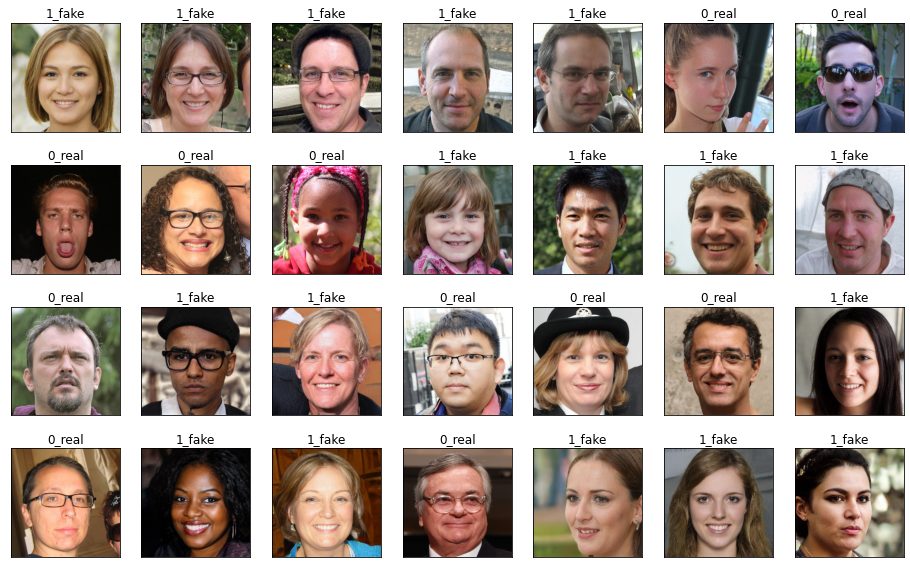

In [5]:
plt.figure(figsize = (16,10))
for i in range(28):
    random = np.random.randint(1,len(dataset))
    plt.subplot(4,7,i+1)
    plt.imshow(plt.imread(dataset.loc[random, 'img_path']))
    plt.title(dataset.loc[random, 'img_status']) 
    plt.xticks([])
    plt.yticks([])
plt.show()   # show some random samples from the data

In [6]:
image_gen = ImageDataGenerator()

In [7]:
train_generator = image_gen.flow_from_directory(path + '/train/', batch_size=100, class_mode='binary')

Found 100000 images belonging to 2 classes.


In [8]:
valid_generator = image_gen.flow_from_directory(path + '/val/', batch_size=100, class_mode='binary')

Found 20000 images belonging to 2 classes.


In [9]:
test_generator = image_gen.flow_from_directory(path + '/test/', batch_size=100, class_mode='binary')

Found 20000 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'0_real': 0, '1_fake': 1}

# Data Processing: Segment Anything Model (SAM)
### Run SAM.py

- Detailed installation instructions are in SAM.py
- run SAM.py on real-vs-fake datasets to obtain result masked images
- Note that the pretrained checkpoint need to be downloaded 
- Sample result masked images are in directory ./real-vs-fake/results_mask

### Click the links below to download the checkpoint for SAM.py model type. (Approximately 2G)

- **`default` or `vit_h`: [ViT-H SAM model.](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth)**

# Feature extraction 
# Learned Noise Patterns (LNP) Calculation: Denoise Network - CycleISP
- We implement the feature extraction codes in CycleISP and form Project_LNP.py to produce LNP images

### Run Project_LNP.py
```
python Project_LNP.py
```
- Note that the pretrained checkpoint is in directory ./sidd_rgb.pth (Already downloaded)
- Run Project_LNP.py on results_mask datasets (Paths were already set)
- Sample result LNP images are in directory ./real-vs-fake/results_mask/LNP

## Results in real extracting process

In [11]:
# extrated faces, LNP

ext_paths = []   # extracted face paths
LNP_paths = []   # extracted LNP paths

for i in range(len(dataset)):
    img_path = dataset.loc[i, 'img_path']
    ext_paths.append(path + '/results_mask/' + '/'.join(img_path.split('.')[-2].split('/')[-3:]) + '.jpg')
    LNP_paths.append(path + '/results_mask/LNP/' + '/'.join(img_path.split('.')[-2].split('/')[-3:]) + '.png')

dataset['ext_path'] = np.array(ext_paths)
dataset['LNP_path'] = np.array(LNP_paths)
dataset.to_csv('image_paths.csv', index = False, sep = ',')

# Feature Fusion: LNP, LNP amplitude, LNP phase - Fourier transform
- In our code, the amplitude spectrum and phase spectrum are generated in classification model backbone
- We visualize the LNP, A.S. and P.S. as below

In [1]:
def deal_color(img):   # cv2: [b,g,r] -> plt: [r,g,b]
    b, g, r = cv2.split(img)
    img_rgb = cv2.merge([r, g, b])
    return img_rgb


def fftshift2d(input):
    c, h, w = input.shape
    fs11 = input[:, -h  // 2:h, -w  // 2:w]
    fs12 = input[:, -h  // 2:h, 0:w // 2  ]
    fs21 = input[:, 0:h // 2 ,  -w  // 2:w]
    fs22 = input[:, 0:h // 2 ,  0:w // 2  ]
    output = torch.cat([torch.cat([fs11, fs21], axis=1), torch.cat([fs12, fs22], axis=1)], axis=2)
    return output


def normalize(arr):
    a = arr.max()
    b = arr.min()
    arr = (arr - b) / (a - b)
    return arr

In [15]:
# show LNP, LNP amplitude, LNP phase of a single image

def show_single(df, fgray=False):
    
    plt.figure(figsize = (16,16))
    
    for i in range(4):
        random = np.random.randint(1,len(df))

        pri_img = cv2.imread(df.loc[random, 'img_path'])   # show
        LNP_img = cv2.imread(df.loc[random, 'LNP_path'])   # show

        if fgray == False:
            x = torch.from_numpy(np.transpose(LNP_img,(2,0,1)))
            f = fft.fftn(x, dim=(1,2), norm='ortho')

            f_amplitude = fftshift2d(20 * torch.log(torch.abs(f) + 1e-8))
            #f_amplitude = fftshift2d(torch.pow(torch.abs(f) + 1e-8, 0.8))
            f_amplitude = np.transpose(f_amplitude.numpy(), (1,2,0))
            f_amplitude = normalize(f_amplitude)  # show

            f_phase = fftshift2d(torch.atan2(f.imag + 1e-8, f.real + 1e-8))
            f_phase = np.transpose(f_phase.numpy(), (1,2,0))
            f_phase = normalize(f_phase)  # show

            # show
            imgs = [deal_color(pri_img), deal_color(LNP_img), deal_color(f_amplitude), deal_color(f_phase)]
            cmaps = [None]*4
            titles = [df.loc[random, 'img_status'], 'LNP (3-channel)', 
                      'LNP amplitude (3-channel)', 'LNP phase (3-channel)']
        
        else:   # fgray == True
            g = cv2.cvtColor(LNP_img, cv2.COLOR_BGR2GRAY)
            f = np.fft.fft2(g)
            fshift = np.fft.fftshift(f)

            f_amplitude = 20*np.log(np.abs(fshift))   # show
            f_phase = np.angle(fshift)   # show

            # show
            imgs = [deal_color(pri_img), deal_color(LNP_img), f_amplitude, f_phase]
            cmaps = [None]*2 + ['gray']*2
            titles = [df.loc[random, 'img_status'], 'LNP (3-channel)', 
                      'LNP amplitude (1-channel)', 'LNP phase (1-channel)']

        for j in range(4):
            plt.subplot(4, 4, 4*i+j+1)
            plt.title(titles[j])
            plt.imshow(imgs[j], cmap=cmaps[j])
            plt.xticks([])
            plt.yticks([])                  
            
    plt.show()

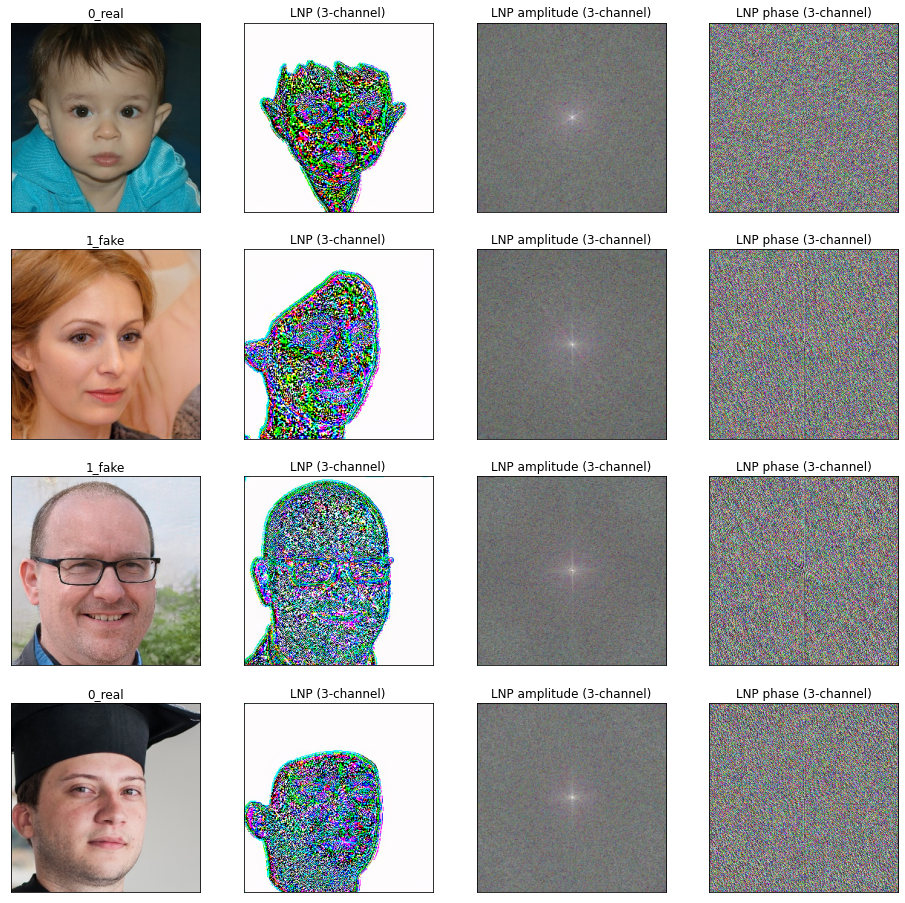

In [40]:
show_single(df=extset, fgray=False)
#show_single(df=extset, fgray=True)

# Feature Fusion: LNP, LNP amplitude, LNP phase - Fourier transform
- In our code, the amplitude spectrum and phase spectrum are generated in classification model backbone
- We visualize the LNP, A.S. and P.S. as below

# Classification: ResNet50 and Mobilenetv2  -CNNDetection
- We take the produced LNP dataset (./real-vs-fake/results_mask/LNP) and sort it mainly using the code provided by [CNNDetection](https://github.com/peterwang512/CNNDetection)
- We add channel attention block, Mobilenetv2 network in our implementation

## Training Process

### In training classification model, we test 3 different feature fusion mechanisms and 2 backbone classification models, in total generate 6 trained model checkpoints, the real trained model checkpoints can be downloaded at **[checkpoints](https://drive.google.com/drive/folders/17PNe9G3wmxFxqzfOV0g8zlUqzVfS9Djj)** , and saved under the directory ./checkpoints

### - The accuracy of each mode and backbone is listed in the table

![avatar](./table_md.png)

### Three feature fusion mechanisms: 
#### Mode 0 : Concat [Channel Attention(A.S. + P.S.), LNP]
#### Mode 1 : Channel Attention[Concat(A.S.+P.S.+LNP)]
#### Mode 2 : Concat(A.S.+P.S.+LNP)

### Two classification networks:
#### arch=res50 : Resnet50 
#### arch=mobilev2 : MobilenetV2

### Click the links below to download the checkpoint for resnet50 pretrain model and save it under directory: ./pretrained，rename it to resnet50.pth

- ** [res50_pretrained](https://download.pytorch.org/models/resnet50-19c8e357.pth)**
- mobilenetv2 checkpoint is already in directory ./pretrained

###  Run train.py by the following line
###  In this example, use mode 0 and arch=mobilenetv2
### The train process can be run on sample datasets(train: 10 val: 2 test: 2) and save the trained models under directory: ./checkpoints

```
python train.py --name mob_mode0_cha --dataroot ./real-vs-fake/results_mask/LNP --classes=face --arch=mobilev2 --train_mode=0
```

## Testing Process

### In testing process, we load different model from directory: ./checkpoints to test the effect of 3 feature fusion mechanisms and 2 classification models

### Run demo_dir.py by the following line, in this sample we still use mode=0 and arch=mobilenetv2


```
python demo_dir.py --backbone=mobilev2 --mode=0 --model_path=./checkpoints/mob_mode0_cha/model_epoch_best.pth 

```

### To load real trained models and test on real test dataset(10k real & 10k fake), download the **[test dataset](https://drive.google.com/drive/folders/17PNe9G3wmxFxqzfOV0g8zlUqzVfS9Djj)** and use the downloaded checkpoints model path to predict results and accuracy.